In [1]:
#import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
# from keras.models import Sequential
# from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Bidirectional

In [2]:
# Read the dataset
df = pd.read_csv('../Dataset/VCB-Historical-Data_Group-9.csv',index_col='Date', parse_dates=True)
df.dropna() #Drop missing value
df = df.sort_values(by='Date', ascending=True)
df =df.reset_index(drop=True) #Reset the index
print(df)

       Price    Open    High     Low     Vol. Change %
0     47,765  46,844  47,765  46,690  910.43K    2.81%
1     48,226  47,765  48,379  47,765    1.72M    0.97%
2     48,379  48,226  48,994  47,995    2.01M    0.32%
3     48,149  48,456  48,610  47,535    1.38M   -0.48%
4     48,456  48,149  48,994  48,072    2.42M    0.64%
...      ...     ...     ...     ...      ...      ...
1308  90,200  90,400  90,600  89,700    1.06M    0.00%
1309  90,700  89,800  90,700  89,800    1.35M    0.55%
1310  89,800  90,800  91,000  89,800    1.19M   -0.99%
1311  88,600  89,500  89,700  88,500    2.36M   -1.34%
1312  87,200  88,700  89,000  87,200    3.92M   -1.58%

[1313 rows x 6 columns]


In [3]:
print(df.dtypes)

Price       object
Open        object
High        object
Low         object
Vol.        object
Change %    object
dtype: object


In [4]:
# Hàm chuyển đổi
def convert_str_to_number(str):
    return float(str.replace(',', ''))

def convert_change_to_number(change_str):
    return float(change_str.strip('%')) / 100

def convert_volume_to_number(volume_str):
    factor = {'K': 1000, 'M': 1000000, 'B': 1000000000}
    return int(float(volume_str[:-1]) * factor[volume_str[-1]]) if volume_str[-1] in factor else int(volume_str)

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'], df['Open'], df['High'], df['Low'] = [df[col].apply(convert_str_to_number) for col in ['Price', 'Open', 'High', 'Low']]
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

print(df)
df.describe()

        Price     Open     High      Low     Vol.  Change %
0     47765.0  46844.0  47765.0  46690.0   910430    0.0281
1     48226.0  47765.0  48379.0  47765.0  1720000    0.0097
2     48379.0  48226.0  48994.0  47995.0  2009999    0.0032
3     48149.0  48456.0  48610.0  47535.0  1380000   -0.0048
4     48456.0  48149.0  48994.0  48072.0  2420000    0.0064
...       ...      ...      ...      ...      ...       ...
1308  90200.0  90400.0  90600.0  89700.0  1060000    0.0000
1309  90700.0  89800.0  90700.0  89800.0  1350000    0.0055
1310  89800.0  90800.0  91000.0  89800.0  1190000   -0.0099
1311  88600.0  89500.0  89700.0  88500.0  2360000   -0.0134
1312  87200.0  88700.0  89000.0  87200.0  3920000   -0.0158

[1313 rows x 6 columns]


,Price,Open,High,Low,Vol.,Change %
count,1313.000000,1313.000000,1313.000000,1313.000000,1.313000e+03,1313.000000
mean,72471.978675,72424.153085,73233.866717,71622.597867,1.361500e+06,0.000628
std,11823.011892,11856.644405,11887.268082,11751.982547,7.560500e+05,0.017210
min,43925.000000,43925.000000,44847.000000,43465.000000,1.804900e+05,-0.149200
25%,63760.000000,63892.000000,64606.000000,63336.000000,8.581200e+05,-0.008400
50%,73238.000000,73316.000000,74167.000000,72387.000000,1.210000e+06,0.000000
75%,80900.000000,80694.000000,81755.000000,79819.000000,1.700000e+06,0.008900
max,97400.000000,98500.000000,100500.000000,97300.000000,8.010000e+06,0.069200


In [5]:
df1=df.reset_index()['Price']
df1

0       47765.0
1       48226.0
2       48379.0
3       48149.0
4       48456.0
         ...   
1308    90200.0
1309    90700.0
1310    89800.0
1311    88600.0
1312    87200.0
Name: Price, Length: 1313, dtype: float64

In [6]:
# 3. Split into train and test sets
train_size = int(0.8 * len(df))
test_size = len(df)-train_size

train_data = df[:train_size]
test_data = df[train_size:]
train_data

,Price,Open,High,Low,Vol.,Change %
0,47765.0,46844.0,47765.0,46690.0,910430,0.0281
1,48226.0,47765.0,48379.0,47765.0,1720000,0.0097
2,48379.0,48226.0,48994.0,47995.0,2009999,0.0032
3,48149.0,48456.0,48610.0,47535.0,1380000,-0.0048
4,48456.0,48149.0,48994.0,48072.0,2420000,0.0064
...,...,...,...,...,...,...
1045,78747.0,76207.0,78916.0,76037.0,1770000,0.0356
1046,78154.0,78747.0,79509.0,78154.0,665380,-0.0075
1047,77900.0,77815.0,78747.0,77561.0,492950,-0.0033
1048,77053.0,77900.0,77985.0,77053.0,597110,-0.0109


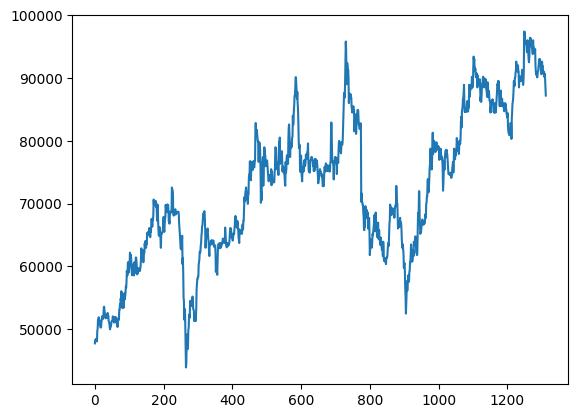

In [7]:
plt.plot(df1)

In [8]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [9]:
# df1.shape
print(df1)

[[0.07180926]
 [0.08043011]
 [0.08329126]
 ...
 [0.85787751]
 [0.83543712]
 [0.80925666]]


In [10]:
# 4. split the data into train and test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [11]:
#Training process
# a. convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

# b. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [12]:
print(X_train)

[[0.07180926 0.08043011 0.08329126 ... 0.31306218 0.31164095 0.28291725]
 [0.08043011 0.08329126 0.07899018 ... 0.31164095 0.28291725 0.29439925]
 [0.08329126 0.07899018 0.08473118 ... 0.28291725 0.29439925 0.30588125]
 ...
 [0.42158018 0.39783076 0.40258065 ... 0.57991585 0.60050491 0.6511828 ]
 [0.39783076 0.40258065 0.40417017 ... 0.60050491 0.6511828  0.6400935 ]
 [0.40258065 0.40417017 0.41683029 ... 0.6511828  0.6400935  0.63534362]]


In [13]:
# 8. Define GRU Model
model = xgb.XGBRegressor(
                        objective='reg:squarederror',
                        n_estimators=1000,
                        learning_rate=0.01,
                        max_depth=6,
                        subsample=0.8,
                        colsample_bytree=0.8)

In [14]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [15]:
# 7. Dự báo dữ liệu test, val
y_pred=model.predict(X_test)
y_pred

array([0.7056023 , 0.70450723, 0.59053415, 0.6006196 , 0.5893231 ,
       0.65885955, 0.67964005, 0.66185653, 0.6802304 , 0.66310024,
       0.6601894 , 0.66069865, 0.59026206, 0.59008443, 0.5900341 ,
       0.6595019 , 0.6592581 , 0.58716327, 0.6006405 , 0.6585386 ,
       0.6780095 , 0.68385607, 0.7822585 , 0.7176077 , 0.7836845 ,
       0.71810836, 0.7825114 , 0.6947613 , 0.66828936, 0.66002476,
       0.6597978 , 0.68277293, 0.71379083, 0.6683113 , 0.66102344,
       0.680299  , 0.68216026, 0.6629845 , 0.6610225 , 0.66031843,
       0.659979  , 0.6024179 , 0.5900812 , 0.60323775, 0.66095823,
       0.60241205, 0.6593327 , 0.60405636, 0.6037837 , 0.59051603,
       0.5898261 , 0.5887055 , 0.5893284 , 0.5410855 , 0.52517873,
       0.5225962 , 0.52237684, 0.529643  , 0.52883464, 0.5182584 ,
       0.51775146, 0.5152635 , 0.5192697 , 0.5371042 , 0.5645493 ,
       0.5827426 , 0.65872824, 0.67872113, 0.6812136 , 0.6858715 ,
       0.7827753 , 0.7878032 , 0.7179523 , 0.78174645, 0.78516

In [16]:
# 12. inverse transform the scaled ytest data back to its original scale.
y_pred_ = scaler.inverse_transform(y_pred.reshape(-1,1))
y_test_ = scaler.inverse_transform(y_test.reshape(-1,1))
# 12. Đánh giá độ chính xác thuật toán 
test_rmse = np.sqrt(np.mean((y_pred_ - y_test_)**2))
print('Testing RMSE:', test_rmse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test_, y_pred_)
print('Testing MAE:', test_mae)

from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test_, y_pred_)
print('Testing MAPE:', test_mape)  

Testing RMSE: 6840.843640592824
Testing MAE: 6489.127459490741
Testing MAPE: 0.07309934537140138


In [17]:
#Dự đoán 30 ngày tiếp theo
x_input = test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = time_step
i = 0
pred_days = 30
while(i < pred_days):
    
    if(len(temp_input) > time_step):
        
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        
        yhat = model.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i = i+1
        
    else:
        yhat = model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i = i+1
        
print("Output of predicted next days: ", lst_output)

1 day output [0.5567671]
2 day output [0.5243316]
3 day output [0.50779164]
4 day output [0.50657636]
5 day output [0.5033872]
6 day output [0.5009016]
7 day output [0.50016844]
8 day output [0.4993982]
9 day output [0.49775854]
10 day output [0.49494347]
11 day output [0.49589637]
12 day output [0.4925101]
13 day output [0.48570058]
14 day output [0.4639555]
15 day output [0.43962213]
16 day output [0.42798272]
17 day output [0.4350269]
18 day output [0.44034514]
19 day output [0.43501854]
20 day output [0.4423134]
21 day output [0.43624765]
22 day output [0.4335476]
23 day output [0.4361159]
24 day output [0.43612182]
25 day output [0.43079007]
26 day output [0.43415645]
27 day output [0.43803552]
28 day output [0.43255365]
29 day output [0.43692]
Output of predicted next days:  [0.6911677718162537, 0.5567671060562134, 0.5243316292762756, 0.5077916383743286, 0.5065763592720032, 0.5033872127532959, 0.5009015798568726, 0.5001684427261353, 0.49939820170402527, 0.49775853753089905, 0.494

In [18]:
y_pred = y_pred.reshape(-1,1)
y_pred = scaler.inverse_transform(y_pred)

print("Test data prediction:", y_pred.shape)

Test data prediction: (162, 1)


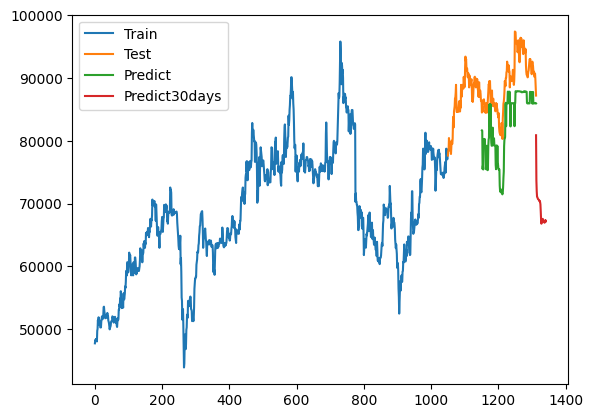

In [19]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)-1+len(scaler.inverse_transform(np.array(lst_output).reshape(-1,1))), step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(np.array(lst_output).reshape(-1,1)))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [20]:
#Dự đoán 60 ngày tiếp theo
x_input = test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = time_step
i = 0
pred_days = 60
while(i < pred_days):
    
    if(len(temp_input) > time_step):
        
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        
        yhat = model.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i = i+1
        
    else:
        yhat = model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i = i+1
        
print("Output of predicted next days: ", lst_output)

1 day output [0.5567671]
2 day output [0.5243316]
3 day output [0.50779164]
4 day output [0.50657636]
5 day output [0.5033872]
6 day output [0.5009016]
7 day output [0.50016844]
8 day output [0.4993982]
9 day output [0.49775854]
10 day output [0.49494347]
11 day output [0.49589637]
12 day output [0.4925101]
13 day output [0.48570058]
14 day output [0.4639555]
15 day output [0.43962213]
16 day output [0.42798272]
17 day output [0.4350269]
18 day output [0.44034514]
19 day output [0.43501854]
20 day output [0.4423134]
21 day output [0.43624765]
22 day output [0.4335476]
23 day output [0.4361159]
24 day output [0.43612182]
25 day output [0.43079007]
26 day output [0.43415645]
27 day output [0.43803552]
28 day output [0.43255365]
29 day output [0.43692]
30 day output [0.43273756]
31 day output [0.43525538]
32 day output [0.42706984]
33 day output [0.43791062]
34 day output [0.4344709]
35 day output [0.438831]
36 day output [0.4386317]
37 day output [0.43747392]
38 day output [0.43825823]
3

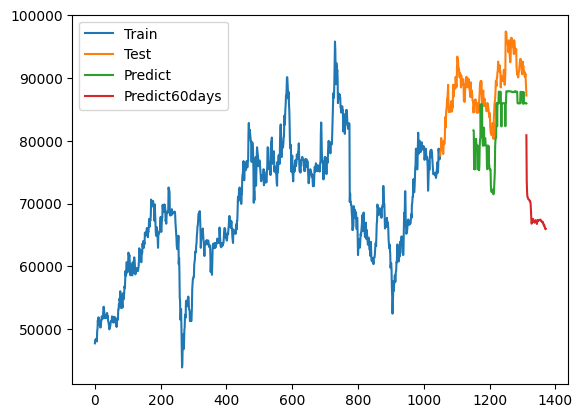

In [21]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)-1+len(scaler.inverse_transform(np.array(lst_output).reshape(-1,1))), step=1)
plt.plot(prediect_data_index, scaler.inverse_transform(np.array(lst_output).reshape(-1,1)))

plt.legend(['Train', 'Test', 'Predict', 'Predict60days'])
plt.show()

In [22]:
#Dự đoán 90 ngày tiếp theo
x_input = test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = time_step
i = 0
pred_days = 90
while(i < pred_days):
    
    if(len(temp_input) > time_step):
        
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        
        yhat = model.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i = i+1
        
    else:
        yhat = model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i = i+1
        
print("Output of predicted next days: ", lst_output)

1 day output [0.5567671]
2 day output [0.5243316]
3 day output [0.50779164]
4 day output [0.50657636]
5 day output [0.5033872]
6 day output [0.5009016]
7 day output [0.50016844]
8 day output [0.4993982]
9 day output [0.49775854]
10 day output [0.49494347]
11 day output [0.49589637]
12 day output [0.4925101]
13 day output [0.48570058]
14 day output [0.4639555]
15 day output [0.43962213]
16 day output [0.42798272]
17 day output [0.4350269]
18 day output [0.44034514]
19 day output [0.43501854]
20 day output [0.4423134]
21 day output [0.43624765]
22 day output [0.4335476]
23 day output [0.4361159]
24 day output [0.43612182]
25 day output [0.43079007]
26 day output [0.43415645]
27 day output [0.43803552]
28 day output [0.43255365]
29 day output [0.43692]
30 day output [0.43273756]
31 day output [0.43525538]
32 day output [0.42706984]
33 day output [0.43791062]
34 day output [0.4344709]
35 day output [0.438831]
36 day output [0.4386317]
37 day output [0.43747392]
38 day output [0.43825823]
3

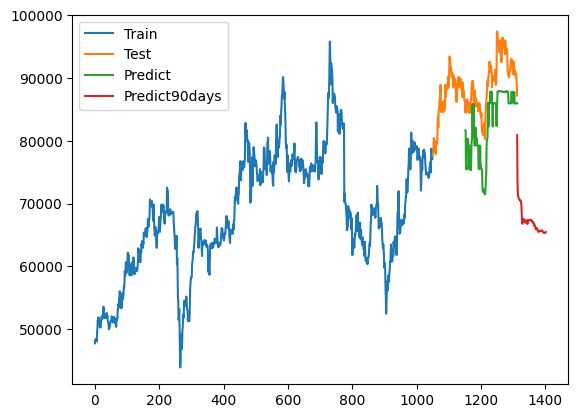

In [23]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)-1+len(scaler.inverse_transform(np.array(lst_output).reshape(-1,1))), step=1)
plt.plot(prediect_data_index, scaler.inverse_transform(np.array(lst_output).reshape(-1,1)))

plt.legend(['Train', 'Test', 'Predict', 'Predict90days'])
plt.show()